In [2]:
# Import libraries

import pandas as pd
import numpy as np
import re
import os

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans

from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /Users/sven/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sven/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/sven/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Part 1: Sentiment Analysis

In [3]:
# Load the dataset

# Path to the specific CSV file
file_path = "archive/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv"

# Load the CSV into a DataFrame
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print(df.head())

                     id             dateAdded           dateUpdated  \
0  AVqVGZNvQMlgsOJE6eUY  2017-03-03T16:56:05Z  2018-10-25T16:36:31Z   
1  AVqVGZNvQMlgsOJE6eUY  2017-03-03T16:56:05Z  2018-10-25T16:36:31Z   
2  AVqVGZNvQMlgsOJE6eUY  2017-03-03T16:56:05Z  2018-10-25T16:36:31Z   
3  AVqVGZNvQMlgsOJE6eUY  2017-03-03T16:56:05Z  2018-10-25T16:36:31Z   
4  AVqVGZNvQMlgsOJE6eUY  2017-03-03T16:56:05Z  2018-10-25T16:36:31Z   

                                                name       asins   brand  \
0  Amazon Kindle E-Reader 6" Wifi (8th Generation...  B00ZV9PXP2  Amazon   
1  Amazon Kindle E-Reader 6" Wifi (8th Generation...  B00ZV9PXP2  Amazon   
2  Amazon Kindle E-Reader 6" Wifi (8th Generation...  B00ZV9PXP2  Amazon   
3  Amazon Kindle E-Reader 6" Wifi (8th Generation...  B00ZV9PXP2  Amazon   
4  Amazon Kindle E-Reader 6" Wifi (8th Generation...  B00ZV9PXP2  Amazon   

                                          categories primaryCategories  \
0  Computers,Electronics Features,Tablets,

In [6]:
# Inspect data

print(df.info())

# findings: 
# - there are some features with missing data that we should remove (especially reviews.id)
# - other features show data but are likely irrelevant for our sentiment analysis and can also be removed (e.g. reviews.username)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   5000 non-null   object 
 1   dateAdded            5000 non-null   object 
 2   dateUpdated          5000 non-null   object 
 3   name                 5000 non-null   object 
 4   asins                5000 non-null   object 
 5   brand                5000 non-null   object 
 6   categories           5000 non-null   object 
 7   primaryCategories    5000 non-null   object 
 8   imageURLs            5000 non-null   object 
 9   keys                 5000 non-null   object 
 10  manufacturer         5000 non-null   object 
 11  manufacturerNumber   5000 non-null   object 
 12  reviews.date         5000 non-null   object 
 13  reviews.dateAdded    1052 non-null   object 
 14  reviews.dateSeen     5000 non-null   object 
 15  reviews.doRecommend  5000 non-null   b

In [4]:
# Check sum of NaN values in each column
nan_counts = df.isna().sum()

print(nan_counts)

id                        0
dateAdded                 0
dateUpdated               0
name                      0
asins                     0
brand                     0
categories                0
primaryCategories         0
imageURLs                 0
keys                      0
manufacturer              0
manufacturerNumber        0
reviews.date              0
reviews.dateAdded      3948
reviews.dateSeen          0
reviews.doRecommend       0
reviews.id             4971
reviews.numHelpful        0
reviews.rating            0
reviews.sourceURLs        0
reviews.text              0
reviews.title            13
reviews.username          1
sourceURLs                0
dtype: int64


In [8]:
print(df.describe())

# findings: 
# - reviews.rating contains mostly positive ratings
# - reviews.numHelpful shows mostly 0 as value but also very high outliers

         reviews.id  reviews.numHelpful  reviews.rating
count  2.900000e+01         5000.000000     5000.000000
mean   1.858740e+08            0.312400        4.596800
std    2.084040e+07            3.111582        0.731804
min    1.082112e+08            0.000000        1.000000
25%    1.851185e+08            0.000000        4.000000
50%    1.880757e+08            0.000000        5.000000
75%    1.981949e+08            0.000000        5.000000
max    2.027812e+08          105.000000        5.000000


In [9]:
print(df['reviews.rating'].unique())

print(df['reviews.rating'].value_counts())


[3 5 4 1 2]
reviews.rating
5    3478
4    1208
3     197
1      63
2      54
Name: count, dtype: int64


In [11]:
# Drop columns containing almost only NaNs:

df_analysis = df.drop(columns=['reviews.dateAdded','reviews.id'])

print(df_analysis.columns)

Index(['id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand',
       'categories', 'primaryCategories', 'imageURLs', 'keys', 'manufacturer',
       'manufacturerNumber', 'reviews.date', 'reviews.dateSeen',
       'reviews.doRecommend', 'reviews.numHelpful', 'reviews.rating',
       'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.username', 'sourceURLs'],
      dtype='object')


In [14]:
# Replacing NaN values in 'reviews.title' and 'reviews.username' with "unknown"

df_analysis['reviews.title'] = df_analysis['reviews.title'].fillna('unknown')
df_analysis['reviews.username'] = df_analysis['reviews.username'].fillna('unknown')

In [16]:
# Concatenate 'reviews.text' and 'reviews.title' into a new column 'reviews_full_text'
df_analysis['reviews_full_text'] = df_analysis['reviews.title'].fillna('') + ' ' + df_analysis['reviews.text'].fillna('')

# Check the first few rows of the updated DataFrame
print(df_analysis[['reviews.title', 'reviews.text', 'reviews_full_text']].head())

                                  reviews.title  \
0                                     Too small   
1  Great light reader. Easy to use at the beach   
2                           Great for the price   
3                                   A Great Buy   
4      Solid entry-level Kindle. Great for kids   

                                        reviews.text  \
0  I thought it would be as big as small paper bu...   
1  This kindle is light and easy to use especiall...   
2  Didnt know how much i'd use a kindle so went f...   
3  I am 100 happy with my purchase. I caught it o...   
4  Solid entry level Kindle. Great for kids. Gift...   

                                   reviews_full_text  
0  Too small I thought it would be as big as smal...  
1  Great light reader. Easy to use at the beach T...  
2  Great for the price Didnt know how much i'd us...  
3  A Great Buy I am 100 happy with my purchase. I...  
4  Solid entry-level Kindle. Great for kids Solid...  


In [17]:
# Get the list of stopwords in English
stop_words = set(stopwords.words('english'))

# Apply tokenization first and then remove stopwords
df_analysis['tokens'] = df_analysis['reviews_full_text'].apply(word_tokenize)

# Remove stopwords from the tokens
df_analysis['tokens'] = df_analysis['tokens'].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])

# Lowercase all tokens
df_analysis['tokens'] = df_analysis['tokens'].apply(lambda tokens: [word.lower() for word in tokens])

In [18]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to convert word to its part of speech (POS) for better lemmatization
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun if POS is unknown

# Apply lemmatization to each token (you need to have POS tags as input for more accurate lemmatization)
df_analysis['tokens_lemmatized'] = df_analysis['tokens'].apply(lambda tokens: [
    lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in nltk.pos_tag(tokens)
])

# Join tokens back into text for further processing
df_analysis['lemmatized_text'] = df_analysis['tokens_lemmatized'].apply(lambda tokens: ' '.join(tokens))

# Preview the results
df_analysis[['tokens', 'tokens_lemmatized', 'lemmatized_text']].head()

,tokens,tokens_lemmatized,lemmatized_text
0,"[small, thought, would, big, small, paper, tur...","[small, thought, would, big, small, paper, tur...",small thought would big small paper turn like ...
1,"[great, light, reader, ., easy, use, beach, ki...","[great, light, reader, ., easy, use, beach, ki...",great light reader . easy use beach kindle lig...
2,"[great, price, didnt, know, much, 'd, use, kin...","[great, price, didnt, know, much, 'd, use, kin...",great price didnt know much 'd use kindle go l...
3,"[great, buy, 100, happy, purchase, ., caught, ...","[great, buy, 100, happy, purchase, ., catch, s...",great buy 100 happy purchase . catch sale real...
4,"[solid, entry-level, kindle, ., great, kids, s...","[solid, entry-level, kindle, ., great, kid, so...",solid entry-level kindle . great kid solid ent...


In [19]:
# Vectorizing the tokenized text

# Initialize the TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,  # Use the top 5000 words by importance
    stop_words='english',  # Remove common English stopwords
    ngram_range=(1, 2)  # Consider unigrams and bigrams
)

# Fit and transform the lemmatized text
tfidf_matrix = tfidf.fit_transform(df_analysis['lemmatized_text'])

# Convert the TF-IDF matrix to a dataframe for better interpretability
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(), 
    columns=tfidf.get_feature_names_out()
)

# Display the TF-IDF dataframe (optional, to inspect the results)
print(tfidf_df.head())

    00   10  10 year       100  100 use   11  11 2016  11yr  11yr old   12  \
0  0.0  0.0      0.0  0.000000      0.0  0.0      0.0   0.0       0.0  0.0   
1  0.0  0.0      0.0  0.000000      0.0  0.0      0.0   0.0       0.0  0.0   
2  0.0  0.0      0.0  0.000000      0.0  0.0      0.0   0.0       0.0  0.0   
3  0.0  0.0      0.0  0.124517      0.0  0.0      0.0   0.0       0.0  0.0   
4  0.0  0.0      0.0  0.000000      0.0  0.0      0.0   0.0       0.0  0.0   

   ...  äôs fun  äôs good  äôs great  äôt  äôt know  äôt use  äôt wait  äôve  \
0  ...      0.0       0.0        0.0  0.0       0.0      0.0       0.0   0.0   
1  ...      0.0       0.0        0.0  0.0       0.0      0.0       0.0   0.0   
2  ...      0.0       0.0        0.0  0.0       0.0      0.0       0.0   0.0   
3  ...      0.0       0.0        0.0  0.0       0.0      0.0       0.0   0.0   
4  ...      0.0       0.0        0.0  0.0       0.0      0.0       0.0   0.0   

    äù  äúalexa  
0  0.0      0.0  
1  0.0      0.

In [20]:
# Check if not all rows in matrix contain only zeros

# Count rows where all values are zero
zero_rows = (tfidf_df == 0).all(axis=1).sum()
print(f"Number of rows with all zero values: {zero_rows}")

# Check total rows for comparison
total_rows = tfidf_df.shape[0]
print(f"Total number of rows: {total_rows}")

Number of rows with all zero values: 0
Total number of rows: 5000


In [21]:
# Initialize the sentiment analysis pipeline with truncation enabled
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    tokenizer="distilbert-base-uncased-finetuned-sst-2-english",
    truncation=True  # Truncates input texts longer than 512 tokens
)

# Apply the sentiment analysis pipeline to the reviews
df_analysis['predicted_sentiment'] = df_analysis['reviews_full_text'].apply(
    lambda text: sentiment_pipeline(text)[0]['label']
)

# Map sentiment labels to numeric values and add to new column
df_analysis['predicted_sentiment_numeric'] = df_analysis['predicted_sentiment'].map(
    {'POSITIVE': 1, 'NEGATIVE': -1}
)

/opt/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [22]:
# Compare predictions with ratings
print(df_analysis[['reviews.rating', 'predicted_sentiment_numeric']].head())

   reviews.rating  predicted_sentiment_numeric
0               3                           -1
1               5                            1
2               4                            1
3               5                           -1
4               5                            1


In [23]:
# Calculate agreement rate
correct_predictions = (
    ((df_analysis['reviews.rating'] >= 4) & (df_analysis['predicted_sentiment_numeric'] == 1)) |
    ((df_analysis['reviews.rating'] <= 3) & (df_analysis['predicted_sentiment_numeric'] == -1))
)
accuracy = correct_predictions.mean()
print(f"Agreement rate between model and ratings: {accuracy:.2%}")


Agreement rate between model and ratings: 88.62%


In [24]:
# Filter out misclassified reviews
misclassified_reviews = df_analysis[~correct_predictions]

# Set pandas display option to show complete text
pd.set_option('display.max_colwidth', None)

# Sample 10 misclassified reviews
sample_misclassified_reviews = misclassified_reviews.sample(10, random_state=42)

# Display the misclassified reviews
print(sample_misclassified_reviews[['reviews_full_text', 'reviews.rating', 'predicted_sentiment_numeric']])

                                                                                                                                                                                                                                                                                                                                         reviews_full_text  \
2281                                                                                                                                                         Just OK I'm a big fan of Amazon and their products, but this tablet is just ok. The build quality is great and the image is very good, but the software is mediocre at best. Worth the price.   
986                                                                                                                                             First experience with Alexa I have enjoyed learning about home automation using Echo plus and consumers need to know that this comes with having to buy addi

In [26]:
# Calculate performance metrics

print(classification_report(df_analysis['reviews.rating'].apply(lambda x: 1 if x >= 4 else -1), 
                            df_analysis['predicted_sentiment_numeric']))

              precision    recall  f1-score   support

          -1       0.32      0.74      0.45       314
           1       0.98      0.90      0.94      4686

    accuracy                           0.89      5000
   macro avg       0.65      0.82      0.69      5000
weighted avg       0.94      0.89      0.91      5000



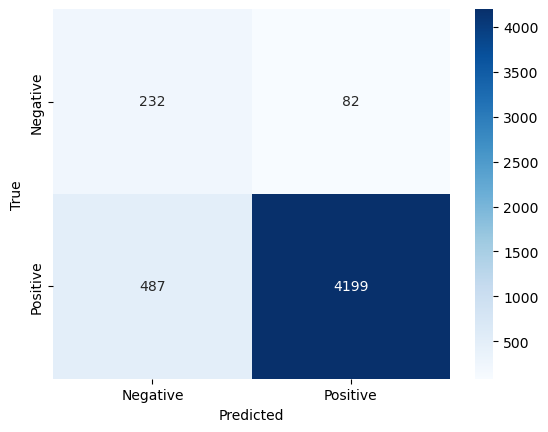

In [27]:
# Visualize performance of model in confusion matrix

cm = confusion_matrix(df_analysis['reviews.rating'].apply(lambda x: 1 if x >= 4 else -1), 
                      df_analysis['predicted_sentiment_numeric'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Step 2: Clustering Products into Meta Categories

In [29]:
# Inspect data in 'categories' and 'primaryCategories' columns

print(df_analysis['categories'].nunique())
print(df_analysis['primaryCategories'].nunique())

23
4


In [31]:
# Display all unique values in 'categories'
print("Unique values in 'categories':")
print(df_analysis['categories'].unique())

# Display all unique values in 'primaryCategories'
print("\nUnique values in 'primaryCategories':")
print(df_analysis['primaryCategories'].unique())

Unique values in 'categories':
['Computers,Electronics Features,Tablets,Electronics,iPad & Tablets,Kindle E-readers,iPad Accessories,Used:Tablets,E-Readers,E-Readers & Accessories,Computers/Tablets & Networking,Used:Computers Accessories,iPads Tablets,All Tablets,Tablets & E-readers,Computers & Tablets,Amazon,Tablets & eBook Readers'
 'Computers,Amazon Echo,Virtual Assistant Speakers,Audio & Video Components,Electronics Features,Computer Accessories,Home & Tools,See more Amazon Echo Show Smart Assistant - White,Smart Home Automation,Electronics,TVs Entertainment,Speakers,Smart Hub & Kits,Digital Device 3,Consumer Electronics,Wireless Speakers,Home Improvement,Amazon Home,Amazon,Computer Speakers,Voice-Enabled Smart Assistants'
 'Amazon Echo,Virtual Assistant Speakers,Electronics Features,Home & Tools,Smart Home Automation,TVs Entertainment,Speakers,Smart Hub & Kits,Digital Device 3,Wireless Speakers,Smart Home,Home Improvement,Voice Assistants,Amazon Home,Amazon'
 'Amazon SMP,TV, Video

In [32]:
# Function to clean text
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'[^\w\s]', '', text.lower())  # Remove punctuation and lowercase
        words = [word for word in text.split() if word not in ENGLISH_STOP_WORDS]  # Remove stopwords
        return ' '.join(words)
    return ''

# Apply cleaning
df_analysis['cleaned_categories'] = df_analysis['categories'].apply(clean_text)
df_analysis['cleaned_primaryCategories'] = df_analysis['primaryCategories'].apply(clean_text)

# Combine columns for clustering
df_analysis['combined_categories'] = (
    df_analysis['cleaned_categories'] + ' ' + df_analysis['cleaned_primaryCategories']
)

In [34]:
# Check for new columns in dataframe
df_analysis.columns

Index(['id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand',
       'categories', 'primaryCategories', 'imageURLs', 'keys', 'manufacturer',
       'manufacturerNumber', 'reviews.date', 'reviews.dateSeen',
       'reviews.doRecommend', 'reviews.numHelpful', 'reviews.rating',
       'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.username', 'sourceURLs', 'reviews_full_text', 'tokens',
       'tokens_lemmatized', 'lemmatized_text', 'predicted_sentiment',
       'predicted_sentiment_numeric', 'cleaned_categories',
       'cleaned_primaryCategories', 'combined_categories'],
      dtype='object')

In [35]:
# Tokenize combined text
df_analysis['categories_tokenized'] = df_analysis['combined_categories'].apply(lambda x: x.split())

In [36]:
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

df_analysis['categories_tokenized'] = df_analysis['categories_tokenized'].apply(lemmatize_tokens)

# Join tokens back into a single string after lemmatization
df_analysis['categories_lemmatized'] = df_analysis['categories_tokenized'].apply(lambda x: ' '.join(x))

In [37]:
# Use TF-IDF to vectorize the text of 'combined_categories'

vectorizer = TfidfVectorizer(max_features=1000)  # Use top 1000 terms
tfidf_matrix_cluster = vectorizer.fit_transform(df_analysis['categories_lemmatized'])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


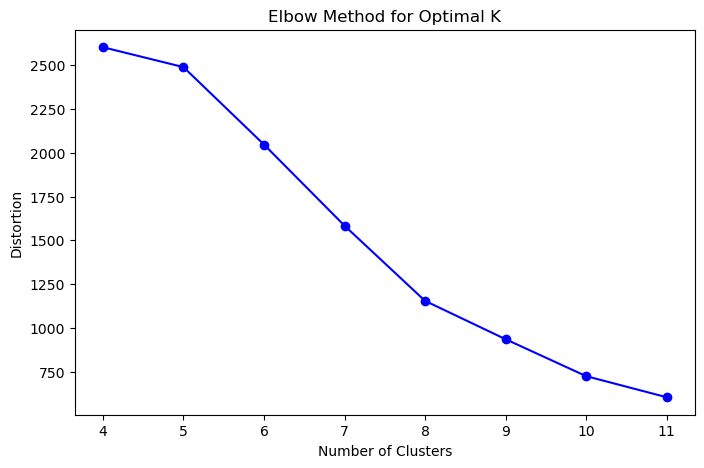

In [38]:
# Use Elbow Method to find optimal number of clusters for k-means

distortions = []
K = range(4, 12)  
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix_cluster)
    distortions.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K, distortions, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal K')
plt.show()

# findings: there is no very clear "elbow" improvement in the chart. The biggest visible point
# of diminishing returns seems to be at 8 clusters.

In [39]:
optimal_k = 8  
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_analysis['cluster'] = kmeans.fit_predict(tfidf_matrix_cluster)

In [40]:
# Get top terms for each cluster
terms = vectorizer.get_feature_names_out()
for i in range(optimal_k):
    cluster_terms = np.argsort(kmeans.cluster_centers_[i])[::-1][:10]
    print(f"Cluster {i} Top Terms: {', '.join(terms[cluster_terms])}")

Cluster 0 Top Terms: tabletsamazon, tabletscomputers, tabletstabletsall, tablet, electronics, office, supplieselectronics, featureswalmart, readerselectronics, book
Cluster 1 Top Terms: assistant, smart, echovirtual, entertainmentspeakerssmart, electronicshardware, kitsdigital, homeamazoncomputer, componentselectronics, speakersaudio, speakersvoiceenabled
Cluster 2 Top Terms: echosmart, automationvoice, improvementsmart, homeamazonsmart, toolshome, homenetworkinghome, assistantsamazon, electronicshardware, kitsdigital, hub
Cluster 3 Top Terms: tabletsfire, tabletsall, tabletstabletscomputers, electronicsipad, tablet, electronics, tabletscomputers, tabletsandroid, tabletselectronicsipad, connected
Cluster 4 Top Terms: musiccomputers, tabletscases, tabletselectronicskids, tabletsipad, computersfire, accessoriestabletstop, bagselectronics, ratedamazon, tabletselectronics, toy
Cluster 5 Top Terms: wireless, bluetooth, player, home, garage, radio, audiomp3, automation, automationmobile, sto

In [42]:
# Define a mapping of cluster numbers to meta names
cluster_meta_names = {
    0: "E-Readers and Book-Focused Tablets",
    1: "Smart Speakers and Assistants",
    2: "Home Automation and Smart Hubs",
    3: "General Tablets and Android Devices",
    4: "Tablet Accessories and Kids' Tablets",
    5: "Wireless Audio and Radios",
    6: "E-Readers and Digital Content Devices",
    7: "Networking and Computing Tablets"
}

# Assign meta names to clusters
df_analysis['meta_category'] = df_analysis['cluster'].map(cluster_meta_names)

# Display some rows to verify the result
print(df_analysis[['combined_categories', 'cluster', 'meta_category']].head(10))

                                                                                                                                                                                                                                                                     combined_categories  \
0  computerselectronics featurestabletselectronicsipad tabletskindle ereadersipad accessoriesusedtabletsereadersereaders accessoriescomputerstablets networkingusedcomputers accessoriesipads tabletsall tabletstablets ereaderscomputers tabletsamazontablets ebook readers electronics   
1  computerselectronics featurestabletselectronicsipad tabletskindle ereadersipad accessoriesusedtabletsereadersereaders accessoriescomputerstablets networkingusedcomputers accessoriesipads tabletsall tabletstablets ereaderscomputers tabletsamazontablets ebook readers electronics   
2  computerselectronics featurestabletselectronicsipad tabletskindle ereadersipad accessoriesusedtabletsereadersereaders accessoriescomputerstablets

In [43]:
# Iterate through each meta category
for category in df_analysis['meta_category'].unique():
    print(f"Meta Category: {category}")
    # Filter rows for the current category and sample 5 names
    sampled_names = df_analysis[df_analysis['meta_category'] == category]['name'].head(5)
    print(sampled_names.to_list())  # Print as a list for easier readability
    print("-" * 50)  # Separator for clarity

Meta Category: E-Readers and Digital Content Devices
['Amazon Kindle E-Reader 6" Wifi (8th Generation, 2016)', 'Amazon Kindle E-Reader 6" Wifi (8th Generation, 2016)', 'Amazon Kindle E-Reader 6" Wifi (8th Generation, 2016)', 'Amazon Kindle E-Reader 6" Wifi (8th Generation, 2016)', 'Amazon Kindle E-Reader 6" Wifi (8th Generation, 2016)']
--------------------------------------------------
Meta Category: Smart Speakers and Assistants
['Amazon Echo Show Alexa-enabled Bluetooth Speaker with 7" Screen', 'Amazon Echo Show Alexa-enabled Bluetooth Speaker with 7" Screen', 'Amazon Echo Show Alexa-enabled Bluetooth Speaker with 7" Screen', 'Amazon Echo Show Alexa-enabled Bluetooth Speaker with 7" Screen', 'Amazon Echo Show Alexa-enabled Bluetooth Speaker with 7" Screen']
--------------------------------------------------
Meta Category: E-Readers and Book-Focused Tablets
['Amazon Fire TV with 4K Ultra HD and Alexa Voice Remote (Pendant Design) | Streaming Media Player', 'Amazon Fire TV with 4K Ult

Part 3: Generating summaries of product reviews

In [44]:
# Group by product
product_summary_simple = df_analysis.groupby(['meta_category', 'name']).agg(
    positive_reviews=('predicted_sentiment_numeric', lambda x: (x == 1).sum()),
    negative_reviews=('predicted_sentiment_numeric', lambda x: (x == -1).sum())
).reset_index()

In [45]:
# Select Top 3 Products in each Meta Category
top_products = product_summary_simple.groupby('meta_category').apply(
    lambda x: x.nlargest(3, 'positive_reviews')  # Get the top 3 products by positive reviews
).reset_index(drop=True)

/var/folders/t4/gbgxnn9j3sj48qv4ydr2n_100000gn/T/ipykernel_91982/461517791.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_products = product_summary_simple.groupby('meta_category').apply(


In [46]:
# Compare the Top Products
top_products['positive_reviews_difference'] = top_products.groupby('meta_category')['positive_reviews'].transform('max') - top_products['positive_reviews']
top_products['negative_reviews_difference'] = top_products.groupby('meta_category')['negative_reviews'].transform('max') - top_products['negative_reviews']

# Display the top products with their differences
print(top_products[['meta_category', 'name', 'positive_reviews', 'negative_reviews', 'positive_reviews_difference', 'negative_reviews_difference']])

                            meta_category  \
0      E-Readers and Book-Focused Tablets   
1      E-Readers and Book-Focused Tablets   
2      E-Readers and Book-Focused Tablets   
3   E-Readers and Digital Content Devices   
4   E-Readers and Digital Content Devices   
5     General Tablets and Android Devices   
6     General Tablets and Android Devices   
7     General Tablets and Android Devices   
8          Home Automation and Smart Hubs   
9        Networking and Computing Tablets   
10          Smart Speakers and Assistants   
11   Tablet Accessories and Kids' Tablets   
12              Wireless Audio and Radios   

                                                                                           name  \
0                       Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case   
1    Kindle E-reader - White, 6 Glare-Free Touchscreen Display, Wi-Fi - Includes Special Offers   
2   Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 GB - Includes Special 

In [47]:
# Find the Worst Product in Each Category
worst_products = product_summary_simple.groupby('meta_category').apply(
    lambda x: x.nlargest(1, 'negative_reviews')  # Get the product with the most negative reviews
).reset_index(drop=True)

print(worst_products[['meta_category', 'name', 'positive_reviews', 'negative_reviews']])

                           meta_category  \
0     E-Readers and Book-Focused Tablets   
1  E-Readers and Digital Content Devices   
2    General Tablets and Android Devices   
3         Home Automation and Smart Hubs   
4       Networking and Computing Tablets   
5          Smart Speakers and Assistants   
6   Tablet Accessories and Kids' Tablets   
7              Wireless Audio and Radios   

                                                                                       name  \
0                   Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case   
1                     Fire Tablet, 7 Display, Wi-Fi, 16 GB - Includes Special Offers, Black   
2  All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta   
3                                               Amazon - Echo Plus w/ Built-In Hub - Silver   
4                   Brand New Amazon Kindle Fire 16gb 7" Ips Display Tablet Wifi 16 Gb Blue   
5                           Amazo

/var/folders/t4/gbgxnn9j3sj48qv4ydr2n_100000gn/T/ipykernel_91982/1616299340.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  worst_products = product_summary_simple.groupby('meta_category').apply(


In [54]:
# Load Mistral-7B model and tokenizer
model_name = "unsloth/mistral-7b-bnb-4bit"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the 4-bit quantized model
model = AutoModelForCausalLM.from_pretrained(
    model_name, 
    device_map="auto",  # Automatically maps the model to available devices
    trust_remote_code=True,  # Ensures compatibility with custom model code if needed
    load_in_4bit=True  # Indicates that the model is quantized to 4-bit precision
)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


ImportError: Using `bitsandbytes` 8-bit quantization requires Accelerate: `pip install accelerate` and the latest version of bitsandbytes: `pip install -i https://pypi.org/simple/ bitsandbytes`

In [ ]:
# Create a pipeline for text generation
generator = pipeline('text-generation', model=model, tokenizer=tokenizer)

# Test the pipeline
test_input = "Tablets have become an essential device for modern users. The most popular features include"
generated_output = generator(test_input, max_length=100, num_return_sequences=1)
print(generated_output)

In [ ]:
prompt = '''
You are tasked with generating a detailed blog summarizing the top 3 tablets in a given category and the 1 worst tablet in that category. For each tablet, provide:

- **Strengths:** A brief description of the tablet's key advantages.
- **Weaknesses:** A brief description of the tablet's key disadvantages.

Use the following example as a template for structuring your response:

**Example:**

Category: Tablets for Reading

The top 3 tablets in this category:

1. **Amazon Kindle Oasis**
   - *Strengths:* Offers a high-resolution E Ink display with adjustable warm light, providing a comfortable reading experience in various lighting conditions.
   - *Weaknesses:* Priced higher than other e-readers, which may not justify the cost for casual readers.

2. **Kobo Clara HD**
   - *Strengths:* Features a 6-inch Carta E Ink touchscreen with ComfortLight, allowing for easy reading day or night.
   - *Weaknesses:* Limited support for certain eBook formats compared to competitors.

3. **Barnes & Noble Nook GlowLight 3**
   - *Strengths:* Equipped with a 6-inch E Ink Carta HD display and a comfortable design for extended reading sessions.
   - *Weaknesses:* Smaller selection of eBooks compared to other platforms.

The worst product in this category:

**Amazon Fire HD 8**
- *Strengths:* Affordable price point and access to a wide range of Amazon services.
- *Weaknesses:* Not primarily designed for reading; the display is not as sharp as dedicated e-readers, and the device is heavier.

Blog summary:
The "Tablets" category offers a range of devices catering to various needs. Leading the pack is the iPad Pro, known for its exceptional performance and stunning display quality, though its high price point may deter some users. The Samsung Galaxy Tab S7 stands out with its versatile S Pen functionality, but the limited app ecosystem can be a drawback. The Microsoft Surface Pro 7 provides a full desktop experience in a tablet form factor, yet its short battery life is a notable downside. On the other hand, the Amazon Fire HD 10 offers an affordable price, but its subpar display and performance make it less appealing.
'''

In [ ]:
# Generate response
response = generator(prompt, max_length=800, num_return_sequences=1)
print(response[0]['generated_text'])